There is an orginal to this file which will have more links and more explanations for the 'first parts' of this file

In [7]:
#Likely reason this didn't work before is because of imbalance in the dataset - Lets start with location and setting
#https://data.csail.mit.edu/graphics/fivek/
#https://www.geeksforgeeks.org/confusion-matrix-machine-learning/
#https://www.geeksforgeeks.org/deep-learning/handling-class-imbalance-in-pytorch/
#https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToPILImage.html
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
#https://stackoverflow.com/questions/74020233/how-to-plot-confusion-matrix-in-pytorch
#https://docs.pytorch.org/docs/stable/generated/torch.cat.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
#https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
#https://docs.pytorch.org/vision/stable/transforms.html
#https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
#https://docs.pytorch.org/docs/stable/data.html
#https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.MultilabelAccuracy.html
#https://stackoverflow.com/questions/61524717/pytorch-how-to-find-accuracy-for-multi-label-classification
#https://stackoverflow.com/questions/28663856/how-do-i-count-the-occurrence-of-a-certain-item-in-an-ndarray

In [8]:
!pip install torcheval

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import os

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Numpy and Pandas FutureWarnings - ignore them for now, we can fix them later

In [11]:
df = pd.read_csv('categories.csv')
df.head(10)  # Display the first 10 rows of the dataframe - no print means it will be displayed in the IDE

,img_name,location,time_of_day,skyCondition,setting
0,a0001-jmac_DSC1459,outdoor,day,sun_sky,nature
1,a0002-dgw_005,indoor,day,mixed,people
2,a0003-NKIM_MG_8178,outdoor,day,sun_sky,man_made
3,a0004-jmac_MG_1384,outdoor,day,sun_sky,nature
4,a0005-jn_2007_05_10__564,outdoor,day,sun_sky,man_made
5,a0006-IMG_2787,outdoor,day,sun_sky,animals
6,a0007-IMG_2480,outdoor,day,sun_sky,man_made
7,a0008-WP_CRW_3959,indoor,unknown,artificial,people
8,a0009-kme_372,indoor,day,NaN,NaN
9,a0010-jmac_MG_4807,outdoor,day,sun_sky,nature


In [12]:
#All these columns expect img_name are target variables / labels, so we will one-hot encode them - we are doing multi-label classification

#Predicting all labels might help because they could be correlated, so we can use all of them as target variables

#Lets see if we can do all columns as target variables instead of just location and setting
# df = pd.get_dummies(df, columns=['setting', 'location'], dtype="int")  # One-hot encode the categorical columns
df = pd.get_dummies(df, columns=['setting', 'location', 'time_of_day', 'skyCondition'], dtype="int")  # One-hot encode the categorical columns
df.columns

Index(['img_name', 'setting_abstract', 'setting_animals', 'setting_man_made',
       'setting_nature', 'setting_people', 'location_indoor',
       'location_outdoor', 'location_unknown', 'time_of_day_day',
       'time_of_day_dusk', 'time_of_day_night', 'time_of_day_unknown',
       'skyCondition_artificial', 'skyCondition_mixed',
       'skyCondition_sun_sky'],
      dtype='object')

I decided to re-add all the target variabes for this mutli-class classification problem, because they are likely correlated and can help the model learn better.

In [13]:
#Lets see if we can do all columns as target variables / labels instead of just location and setting
#Predicting all labels might help because they could be correlated, so we can use all of them as target variables
#Drop for now
# df.drop(['time_of_day', 'skyCondition'], axis=1, inplace=True)
df.head(10)

,img_name,setting_abstract,setting_animals,setting_man_made,setting_nature,setting_people,location_indoor,location_outdoor,location_unknown,time_of_day_day,time_of_day_dusk,time_of_day_night,time_of_day_unknown,skyCondition_artificial,skyCondition_mixed,skyCondition_sun_sky
0,a0001-jmac_DSC1459,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
1,a0002-dgw_005,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0
2,a0003-NKIM_MG_8178,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
3,a0004-jmac_MG_1384,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
4,a0005-jn_2007_05_10__564,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
5,a0006-IMG_2787,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
6,a0007-IMG_2480,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
7,a0008-WP_CRW_3959,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0
8,a0009-kme_372,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
9,a0010-jmac_MG_4807,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1


After checking confusion matrix and the labels predicted less than 20 times, i decided to remove: 'time_of_day_day', 'time_of_day_dusk', 'time_of_day_night', 'time_of_day_unknown', 'skyCondition_artificial', 'skyCondition_mixed', 'skyCondition_sun_sky', location_unknown'

this was after did what is stated above, so we can just drop these columns now

Check plots/all_features.png for results in confusion matrix

In [14]:
df.drop(['time_of_day_day', 'time_of_day_dusk', 'time_of_day_night', 'time_of_day_unknown', 'skyCondition_artificial', 'skyCondition_mixed', 'skyCondition_sun_sky', 'location_unknown', 'setting_abstract'], axis=1, inplace=True)

#Added setting_abstract because there isn't many so the class weight was really high
df.head(10)

,img_name,setting_animals,setting_man_made,setting_nature,setting_people,location_indoor,location_outdoor
0,a0001-jmac_DSC1459,0,0,1,0,0,1
1,a0002-dgw_005,0,0,0,1,1,0
2,a0003-NKIM_MG_8178,0,1,0,0,0,1
3,a0004-jmac_MG_1384,0,0,1,0,0,1
4,a0005-jn_2007_05_10__564,0,1,0,0,0,1
5,a0006-IMG_2787,1,0,0,0,0,1
6,a0007-IMG_2480,0,1,0,0,0,1
7,a0008-WP_CRW_3959,0,0,0,1,1,0
8,a0009-kme_372,0,0,0,0,1,0
9,a0010-jmac_MG_4807,0,0,1,0,0,1


In [15]:
device = torch.device("cuda")

Now i've organised the files and put them into JPEg forwat with raw_image_converter.py we can have a much simpler and hopefully faster data loading pipeline using torchvision's built in image loading functions

In [16]:
from torchvision.io import decode_image
from torchvision.io import ImageReadMode


class ImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.transform = transform
        self.img_dir = img_dir
        self.bounds = []

        if not self.img_dir:
            raise ValueError(f"No images found in directory: {img_dir}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['img_name']  # Assuming the first column is 'img_name'
        #Get the label tensor from the row, excluding the first column (img_name)
        label = torch.tensor(row[1:], dtype=torch.long)  # Convert the labels to tensor (excluding img_name, which is the input image name)

        img_path = os.path.join(self.img_dir, img_name) + ".jpg" # Full path to the image file
        image = decode_image(img_path, mode=ImageReadMode.RGB) #outputs tensor of shape (C, H, W) where C is the number of channels, H is the height and W is the width

        if self.transform:
            image = self.transform(image)

        return image, label # Exclude the first column (img_name) from the label tensor

In [17]:
# Transformations for the dataset

# These are the standard transformations for the dataset, we will use these for training, testing, and validation
val_test_standard_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.Resize((512, 512)), # Resize the image to 512x512 for consistency and to match the model input size
    transforms.ToTensor(), # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [18]:
#Doing data augmentation for training set to get more data and prevent overfitting
#These are applied to the training set only, not the validation or test set
#They are applied dynamically during training, so sample images will be different each time, effectively increasing the size of the training set


#Training transformations with data augmentation
training_augmentation_transforms = transforms.Compose([
    #Standard transformations for the dataset, we will still use these for training (rest below)
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    #Data augmentation transformations for training
    # p= probability of applying the transformation, 0.2 means 20% chance of applying the transformation
    transforms.RandomHorizontalFlip(p=0.2), # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.2), # Randomly flip the image vertically

    #RandomApply makes any transformation randomly applied with a probability p, so we can apply the same transformation with a probability of 0.2

    #30% chance of:
    transforms.RandomApply(
        [
            transforms.RandomCrop(size=430, pad_if_needed=True)
        ], # Randomly crop the image to 430 in random locations, pad if needed to maintain the size for input to the model (82 pixels on each side, so 82+430+82=512)
        p=0.2),

    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.2), # Randomly adjust the sharpness of the image
    transforms.RandomAdjustSharpness(sharpness_factor=0.5,p=0.2), # Randomly adjust the sharpness of the image

    transforms.Resize((512, 512)), # Resize the image to 512x512 for consistency and to match the model input size
    transforms.ToTensor(), # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

this is a new method for splitting the dataset into training, test, and validation sets, after i found out train_dataset.dataset and test_dataset.dataset were the same object, so any transformations applied to one would apply to the other, which is not what we want.

In [19]:
from sklearn.model_selection import train_test_split
# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42) # 70% training, 30% test
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)  # Split the test set into validation and test sets
#This gives us 70% training, 15% validation, and 15% test sets

Using the new organised images in raw_images_organised with our simpler data loading pipeline using torchvision's built in image loading functions and jpeg format images

In [20]:
train_dataset = ImageDataset(train_df, img_dir='raw_images_organised', transform=training_augmentation_transforms)  # Create the training dataset with data augmentation
test_dataset = ImageDataset(test_df, img_dir='raw_images_organised', transform=val_test_standard_transforms)  # Create the test dataset with standard transformations
val_dataset = ImageDataset(val_df, img_dir='raw_images_organised', transform=val_test_standard_transforms)  # Create the validation dataset with standard transformations

In [21]:
print(train_dataset.transform)
print(test_dataset.transform)
print(val_dataset.transform)

Compose(
      ToPILImage()
      RandomHorizontalFlip(p=0.2)
      RandomVerticalFlip(p=0.2)
      RandomApply(    RandomCrop(size=(430, 430), pad_if_needed=True, fill=0, padding_mode=constant))
      RandomAdjustSharpness(p=0.2, sharpness_factor=2)
      RandomAdjustSharpness(p=0.2, sharpness_factor=0.5)
      RandomGrayscale(p=0.2)
      Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
Compose(
      ToPILImage()
      Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
Compose(
      ToPILImage()
      Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)


In [22]:
# Create data loaders - these allow us to load images in batches for training and testing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Train Image Shape: torch.Size([32, 3, 512, 512])
Train Label Shape: torch.Size([32, 6])
torch.float32
torch.int64


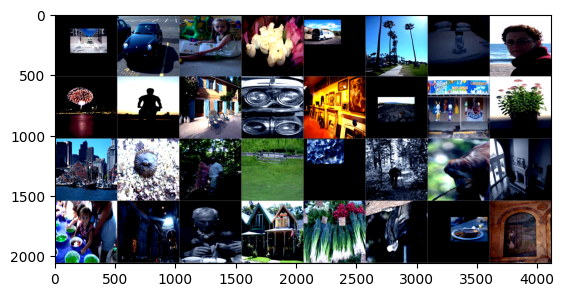

In [23]:
from torchvision.utils import make_grid

train_images, train_labels = next(iter(train_loader))
print(f"Train Image Shape: {train_images.shape}")
print(f"Train Label Shape: {train_labels.shape}")

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print(train_images.dtype)  # Check the shape of the images tensor
print(train_labels.dtype)  # Check the shape of the labels tensor

imshow(make_grid(train_images))

In [24]:
# Compute class weights to handle class imbalance in the dataset
from sklearn.utils.class_weight import compute_class_weight
class_weights_pos = []
for column in df.columns[1:]:  # Skip the first column (img_name) - Go through each feature and get the class weights to handle class imbalance in dataset for loss function input
    class_weight = compute_class_weight(class_weight='balanced',
                                        classes=np.unique(df[column]), # Get unique classes in the column (should be 0 and 1 for binary classification) because of one-hot encoding
                                        y=df[column]) #y is all the values in the column so we can compute the class weights
    print(f"Class weights for {column}: {class_weight[1]}") # Print the weight for the positive class (1)
    class_weights_pos.append(class_weight[1])  # Append the weight for the positive class (1) for each column

class_weights_tensor = torch.tensor(class_weights_pos, dtype=torch.float32)  # Convert to tensor for use in loss function
# Print the class weights
print(f"Class weights: {class_weights_tensor}")

#Higher weight means more rare, so the model will pay more attention to these classes during training

Class weights for setting_animals: 8.333333333333334
Class weights for setting_man_made: 1.337613697164259
Class weights for setting_nature: 2.295684113865932
Class weights for setting_people: 1.8642803877703207
Class weights for location_indoor: 2.3696682464454977
Class weights for location_outdoor: 0.6957973838018369
Class weights: tensor([8.3333, 1.3376, 2.2957, 1.8643, 2.3697, 0.6958])


In [25]:
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor).to(device)  # Using the positive from above class weights to handle class imbalance
#The loss function knows which class to apply these two based on the order of the pos_weight tensor and the order of the columns in the dataframe, so make sure they match
#Loss function needs to be to_device to work with the model on the same device


# Model architecture (better notes in old file model.ipynb)

In [26]:
#https://arxiv.org/pdf/1512.03385
#Decided to copy what paper is doing with kernal sizes etc
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2) # Input channels = 3 (RGB), output channels = 32, kernel size = 5x5, stride = 1, padding = 2 (to keep the spatial dimensions the same)

        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1)

        #Channels are the amount of filters applied to our spatial data, giving depth to our feature map
        #The spatial data will shrink because of 'edge issue' with CNN look at notes for more details
        self.bn7 = nn.BatchNorm2d(256)


        self.avg_global_pool = nn.AdaptiveAvgPool2d(1) # Global average pooling converts our (batch size, num_channels, height width) spatial dimensions into the average per channel across the height and width of the image.
        #This makes our shape (batch_size, num_channels, 1,1) containing just the average per each channel across the image (height and width)
        #for us its (batch_size, 64, 1,1)
        #once flattened this becomes (batch_size, 64 (channels))
        #This avoids us needing a fully connected layer with loads of parameters to deal with the large spatial dimensions


        self.fc1 = nn.Linear(256, len(df.columns) - 1) #Classification layer (new)
        # self.fc1 = nn.Linear(256 * 114 * 114, out_features=len(df.columns) - 1) #Classification layer

    def forward(self, x):
        # Input x is of shape (batch_size, 3, 512, 512)
        x = self.conv1(x)
        x = self.bn1(x)
        #this function()(x) means, create a new instance of the function and apply it to x
        x = nn.ReLU()(x)  # Activation function, done to break the linearity of the model after each convolutional layer



        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)  # Activation function
        x = self.dropout(x)


        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)  # Activation function


        x = self.max_pool(x)  # Max pooling layer, reduces the spatial dimensions by half, you should only pool after a few convolutional layers to reduce the spatial dimensions and retain the features


        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.ReLU()(x)  # Activation function
        x = self.dropout(x)



        x = self.conv5(x)
        x = self.bn5(x)
        x = nn.ReLU()(x)  # Activation function


        x = self.max_pool(x)  # Max pooling layer, reduces the spatial dimensions by half


        x = self.conv6(x)
        x = self.bn6(x)
        x = nn.ReLU()(x)  # Activation function


        x = self.conv7(x)
        x = self.bn7(x)
        x = nn.ReLU()(x)

        x = self.avg_global_pool(x) # Global average pooling, reduces the spatial dimensions to (batch_size, num_channels, 1, 1) by averaging the height and width dimensions per channel
        x = torch.flatten(x, 1)  # Flatten the output to shape (batch_size, num_channels)

        x = self.fc1(x)  # Fully connected layer for classification

        return x

In [27]:
net = Model().to(device)

In [28]:
from torchsummary import summary
# summary(net, input_size=(3, 512, 512)) - doesn't work on MPS device, but works on CPU and CUDA

In [29]:
#Weight_decay sets and enables L2 regularization in the cost function, it adds a penalty to the loss function based on the magnitude of the weights, which helps prevent overfitting by discouraging large weights. 1e-5 is the resNet default.
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)  # Using Adam optimizer with a learning rate of 0.001

In [30]:
#There's a bunch of tensorboard stuff in the pytorch tutorial, we don't need it for now, but we can add it later if we want to visualize the training process

#This function gets called once per epoch in loop below
def train_one_epoch(train_loader,loss_values):

    running_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    total_train_data = len(train_loader)
    for i, data in enumerate(train_loader, 0):  # Start counting from 0, enumerate give us a counter as well as the data
        # Every data instance is an input + label pair

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()  # Move inputs and labels to the same device as the model (apple silicon chip, cuda, or cpu)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = net(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # running_loss is the total loss for the epoch, we will average it later
        running_loss += loss.item()

    avg_loss = running_loss / total_train_data  # Average loss for the epoch (over the all batches in the training set, given by len(train_loader))

    # Log the average loss for the epoch:
    loss_values.append(avg_loss) #log the average loss for the epoch to the loss_values list
    # Log the average loss for the epoch
    return avg_loss, loss_values

In [31]:
# Initialize list and int to keep track of recent training losses and average losses for early stopping

# avg_of_recent_losses = 0.0 #Doesn't work because we cannot reasign a value within our function due to scope, so we will return it from the function

#Early stopping function to stop training if the validation loss doesn't improve for a certain number of epochs (patience)
# Initialize a list to keep track of recent training losses for early stopping
recent_train_losses = []  # List to keep track of recent training losses for early stopping
previous_train_losses = []

#This was broken - made a change idk now
def early_stopping(avg_loss,patience=5):

    if len(recent_train_losses) < patience:
        recent_train_losses.append(avg_loss)  # Add the current average loss to the recent losses

    if len(previous_train_losses) < patience:
        previous_train_losses.append(recent_train_losses[0])
        recent_train_losses.pop(0)

    if len(recent_train_losses) == patience and len(previous_train_losses) == patience:
        avg_of_previous_losses = np.mean(previous_train_losses)
        avg_of_recent_previous_losses = np.mean(recent_train_losses)
        if avg_of_previous_losses < avg_of_recent_previous_losses:
            print(f"Early stopping condition met: {avg_of_previous_losses} < {avg_of_recent_previous_losses}")
            return True, recent_train_losses, previous_train_losses  # Early stopping condition met

        print(f"Early stopping condition not met: {avg_of_previous_losses} >= {avg_of_recent_previous_losses}")
        previous_train_losses.append(recent_train_losses[0])  #Add oldest recent loss to previous losses
        recent_train_losses.pop(0)  # Remove the oldest loss to maintain the size of the list

    return False, recent_train_losses, previous_train_losses  # No early stopping condition met


In [32]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

#There's a bunch of tensorboard stuff in the pytorch tutorial, we don't need it for now, but we can add it later if we want to visualize the training process
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/classifier_trainer{}'.format(timestamp))

EPOCHS = 45

best_vloss = 1_000_000. #Super big number to start with, so we can save the model if the validation loss is lower than this

# Initialize lists to keep track of loss values for plotting later
loss_values = []
val_loss_values = []


total_val_data = len(val_loader)
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1)) # Start counting epochs from 1 for better readability

    # Make sure gradient tracking is on, and do a pass over the data, so we are not in evaluation mode.
    net.train(True)

    #Actually train the model, this is where the training happens
    #Keep track of loss values for plotting later, keep giving the loss_values array to the train_one_epoch function so that it keeps track of the loss values
    avg_loss, loss_values = train_one_epoch(train_loader, loss_values)

    early_stop,recent_train_losses, previous_train_losses = early_stopping(avg_loss,patience=5)  # Check if early stopping condition is met

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    net.eval()

    #This is the validation loop, it will run after each epoch and compute the validation loss
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader, 0): #Computes the validation loss per epoch
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device).float()  # Move inputs and labels to the same device as the model
            voutputs = net(vinputs)
            vloss = criterion(voutputs, vlabels)
            #running vloss is the total validation loss for the epoch, we will average it later
            running_vloss += vloss.item()  # Add the validation loss for this batch to the running validation loss

    # Average validation loss for the epoch (over the all batches in the validation set, given by len(val_loader))
    avg_vloss = running_vloss / total_val_data
    val_loss_values.append(avg_vloss)

    #Gives the loss and validation loss for the epoch into the terminal
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # for both training and validation w]e log the average loss for the epoch
    writer.add_scalars('Training vs. Validation Loss',
                       { 'Training' : avg_loss, 'Validation' : avg_vloss },
                       epoch + 1)
    writer.flush()

    #Track best performance, and save the model's state
    if avg_vloss < best_vloss: #If the validation loss is lower than the best validation loss so far, save the model

        #Best vloss starts at a super high number, so the first model will always be saved
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch + 1) # Save the model with a timestamp and epoch number (epoch + 1 to start from 1)
        torch.save(net.state_dict(), model_path)

    if early_stop:  # Check if early stopping condition is met
        print("Early stopping triggered, stopping training.")
        break  # Stop training if early stopping condition is met

    #Onto the next epoch, which will also run through all the batches in the training set and validation set and give the average los s for the epoch

EPOCH 1:
LOSS train 0.7718531353907152 valid 0.7077025125424067
EPOCH 2:
LOSS train 0.7494351007721641 valid 0.6874437431494395
EPOCH 3:
LOSS train 0.7450473958795721 valid 0.7275280207395554
EPOCH 4:
LOSS train 0.7372718756849116 valid 0.7033310234546661
EPOCH 5:
LOSS train 0.7391347072341226 valid 0.6940211231509844
EPOCH 6:
LOSS train 0.7423999260772358 valid 0.6884633377194405
EPOCH 7:
LOSS train 0.737716362693093 valid 0.6896320059895515
EPOCH 8:
LOSS train 0.7368015403097327 valid 0.705956389506658
EPOCH 9:
LOSS train 0.7368342323736711 valid 0.6829107279578844
EPOCH 10:
Early stopping condition not met: 0.7485484429922972 >= 0.7377267065915194
LOSS train 0.7348814715038646 valid 0.6812719106674194
EPOCH 11:
LOSS train 0.7318245687267997 valid 0.6830289363861084
EPOCH 12:
LOSS train 0.732388002764095 valid 0.6801448787252108
EPOCH 13:
LOSS train 0.7301371135494926 valid 0.6786754528681437
EPOCH 14:
LOSS train 0.7266439372842962 valid 0.6871391708652178
EPOCH 15:
LOSS train 0.7304

In [33]:
# #Resplit dataset for cross validation
# train_size = int(0.8 * len(dataset))  # 80% for training
# test_size = len(dataset) - train_size  # Remaining 20% for testing
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])  # Split the dataset into training and test sets

Below isn't used it was an attempt at cross validation

In [34]:
#Removed it was cross validation code but it was shit

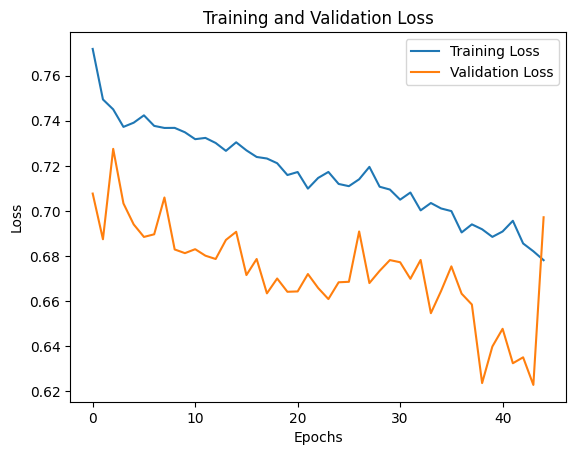

In [35]:
#Plot the training and validation loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [36]:
# net = Model().to(device) # Create a new instance of the model architecture but still with GPU support
# net.load_state_dict(torch.load('model_20250818_204816_43')) #Only imports the weights, not the model architecture
# net = net.to(device) # Create a new instance of the model architecture but still with GPU support

In [37]:
#Training set evaluation
from torcheval.metrics import MultilabelAccuracy #This lib has so many of these - good to use i think
#Per label accuracy much more common for multi label
net.eval() #Turns off dropout layers
metrics = MultilabelAccuracy()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = torch.sigmoid(net(inputs)) #Applying sigmoid because of raw logits, sigmoid makes it into an actual probabilty, only needed during eval
        predicted = outputs > 0.5 #Returns true or false (0,1)
        metrics.update(predicted, labels) #Saves until compute or reset

accuracy = metrics.compute()
print(f'Training MultiLabel Accuracy: {accuracy}')

Training MultiLabel Accuracy: 0.20800000429153442


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
#Testing set evaluation
from torcheval.metrics import MultilabelAccuracy #This lib has so many of these - good to use i think
#Per label accuracy much more common for mutli label models like this
net.eval() #Turns off dropout layers
metrics = MultilabelAccuracy()
#Modified for confusion matrix
predictions = []
labels_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = torch.sigmoid(net(inputs)) #Applying sigmoid because of raw logits, sigmoid makes it into an actual probability, only needed during eval
        predicted = outputs > 0.5 #Returns true or false (0,1) done only during inference, not training because cost function expects raw logits
        predictions.append(predicted)
        labels_list.append(labels) #append all labels that appeared during the test set evaluation
        metrics.update(predicted, labels) #Saves until compute or reset

accuracy = metrics.compute()
print(f'Test MultiLabel Accuracy: {accuracy}')

Test MultiLabel Accuracy: 0.23866666853427887


In [40]:
#Looks like we have overfitting, fix this, attempting dropout regularization - done

Below is prep for the confusion matrix plotted 2 cells below, this is where we get the predictions and labels from the test set evaluation above, so we can plot the confusion matrix and prepare the data for it.

In [41]:
#Plot a confusion matrix (prepping data for it)
#https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# Concatenate all predictions and labels into a single tensor (currently they are lists of tensors)

#Basically by counting the amount of each class number that appear in this tensor, we can get the confusion matrix  (cell below)
all_predictions_tensor = torch.cat(predictions, dim=0) # Concatenate all predictions that appeared in the test set into a single tensor
all_labels_tensor = torch.cat(labels_list, dim=0)  # Concatenate all labels that appeared in the test set into a single tensor


# Convert to CPU tensors then to numpy arrays for confusion matrix
all_predictions_tensor = all_predictions_tensor.cpu().numpy()
all_labels_tensor = all_labels_tensor.cpu().numpy()
print(all_predictions_tensor.shape, all_labels_tensor.shape)  # Check the shapes of the tensors
print(all_predictions_tensor[0].shape, all_labels_tensor[0].shape) # Check the shape of the first prediction and label tensors


#Data datatype before argmax, they are one-hot encoded tensors (boolean tensors) no good for confusion matrix
print(all_predictions_tensor.dtype, all_predictions_tensor.dtype)

# Argmax to convert one-hot encoded predictions and labels to a list of predicted and actual labels as integers
all_predictions_tensor = all_predictions_tensor.argmax(axis=1)
all_labels_tensor = all_labels_tensor.argmax(axis=1)
print(all_predictions_tensor.dtype, all_labels_tensor.dtype)


print(np.unique(all_predictions_tensor))
print(np.unique(all_labels_tensor)) #Aah, there were only 7 unique labels in the test set
# so we need to make sure the confusion matrix doesn't drop the 'empty labels' because the model might still have predicted them, but it could have been wrong


(750, 6) (750, 6)
(6,) (6,)
bool bool
int64 int64
[0 1 2 3 4 5]
[0 1 2 3 4 5]


(6, 6)


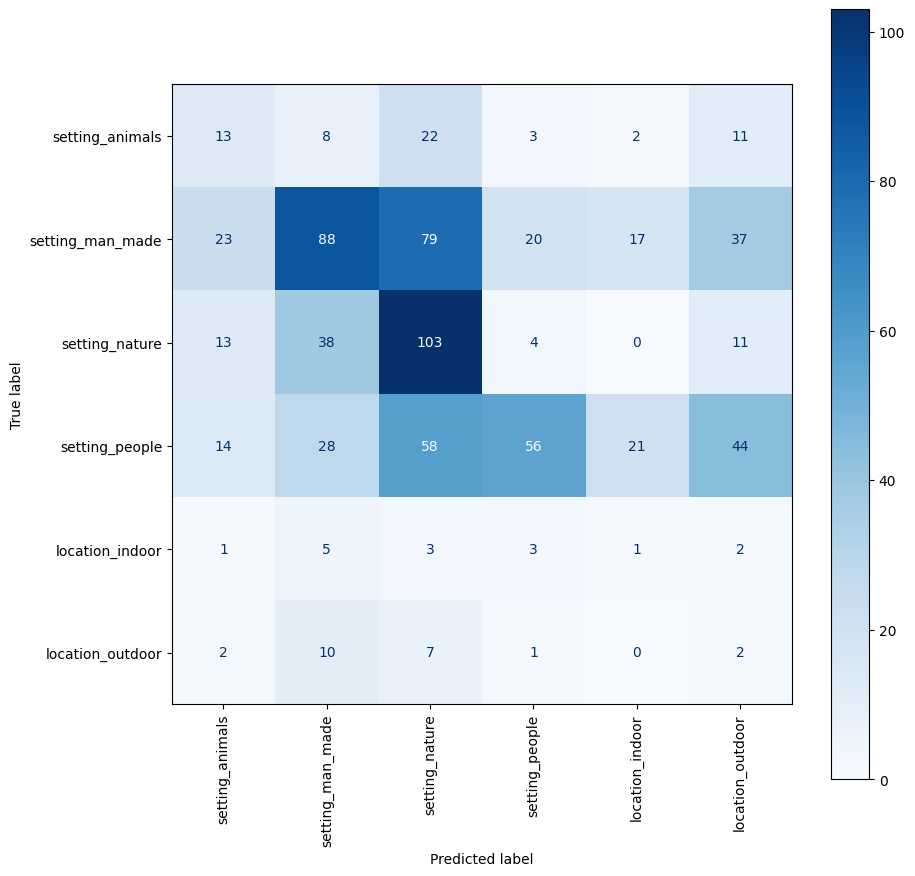

In [42]:
display_labels = df.columns[1:]  # Exclude the first column (img_name) for display labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(all_labels_tensor, all_predictions_tensor, labels=np.arange(len(display_labels)))
#np.arrange basically just creates an array of length of display_labels (array of 15 elements, 0 to 14) which are the labels for the possible labels in the dataset, so the confusion matrix will have 15 rows and 15 columns, one for each label

#Without display_labels the confusion matrix would only render the labels that were actually predicted, so if a label was never predicted, it would not appear in the confusion matrix, which is not what we want

#15 labels, so 15x15 matrix
print(cm.shape)

matrix = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels) #disiplay_labels are the text labels (from column names) for the confusion matrix, these are the labels we want to display on the x and y axis of the confusion matrix, these are the same order as the labels we used for confusion matrix computation above,thanks to np.arrange(), so they will line up correctly

_, ax = plt.subplots(figsize=(10, 10))  # Create a figure and axis for the confusion matrix plot (much larger than default
matrix.plot(cmap='Blues', values_format='d', ax=ax, xticks_rotation=90)  # Plot the confusion matrix with blue color map and integer format


Keep in mind this matrix is from the test set

Only parts of matrix are useful because we are doing multi-label classification, basically just look at the related features from the one-hot.

So for location this would be: True label: location_outdoor, Predicted label: location_indoor or location_outdoor, etc. no point looking at the unrelated features like setting when trying to see how well the model predicts location.

Matrix shows you when the model isn't choosing any labels from a grouping like location, its not choosing any of the one-hot encoded location labels. where as setting, seems much more 'active' in the matrix, meaning the model is choosing labels from that grouping more often.

In [43]:
#Lets get all the labels that were predicted less than 10 times in the test set, so we can see which labels are not being predicted at all
predicted_counts = np.bincount(all_predictions_tensor, minlength=len(display_labels))  # Count the occurrences of each predicted label, minlength ensures we count all labels even if some were not predicted at all

unpredicted_labels = [label for label, count in zip(display_labels, predicted_counts) if count < 20]  # Get labels that were predicted less than 10 times, zip pairs each label with its count, so we can filter them based on the count, this works because they are the same length (thanks to minlenth) and in the same order.


print("Labels predicted less than 10 times:", unpredicted_labels)  # Print the labels that were predicted less than 20 times

#These are the labels that our model can't do so will be removed, likely due to the data imbalance in the dataset, so we will remove them from the dataset and retrain the model

Labels predicted less than 10 times: []


After checking the confusion matrix and the labels predicted less than 20 times, i decided to remove: 'time_of_day_day', 'time_of_day_dusk', 'time_of_day_night', 'time_of_day_unknown', 'skyCondition_artificial', 'skyCondition_mixed', 'skyCondition_sun_sky', location_unknown'

In [44]:
torch.save(net.state_dict(), "final_model_mutlilabel.pth")  # Save the final model state dictionary